### Import the required libraries
Fot this tutorial we have developed two packages, one that stores some text for the style file (\*.sld) and another that generates the Stiff format. There are required packages for the tutorial as pandas, re, and os. 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re, os

from funciones import *
from variables import *

### Define the equivalent concentrations and open the chemistry data
The code converts component concentration to equivalent HCO3 weights and creates a columns with the calculated values for each sample.

In [2]:
#ion dictionary
iones = {
'HCO3': 61, 'CO3' : 30, 'Cl' : 35, 'SO4': 48,
'Na' : 23, 'Ca' : 20, 'Mg' : 12, 'K'  : 39
}

#chemistry dataframe
datosQuimica = pd.read_excel('../InputData/DatosDiagramaStiff.xlsx')

#replace incompatible characters
datosQuimica['Estacion'] = datosQuimica['Estacion'].str.replace("/","_")
datosQuimica['Estacion'] = datosQuimica['Estacion'].str.replace("–","-")
datosQuimica['Estacion'] = datosQuimica['Estacion'].str.replace(" |%/s","")
datosQuimica = datosQuimica.set_index(['Estacion'])

#equivalen weight colum
for ion in iones.keys():
    datosQuimica[str(ion)+'_meq'] = datosQuimica[ion]/iones[ion]

### Generation of images files 
This tutorial generates the Stiff diagram as Png and SVG files. In order to import the Stiff diagram in QGIS we need the image vector file SVG.

In [3]:
for index, row in datosQuimica.iterrows():
    Na_K, Ca, Mg = row['Na_meq']+row['K_meq'], row['Ca_meq'], row['Mg_meq'] 
    Cl, SO4, HCO3_CO3 = row['Cl_meq'], row['SO4_meq'], row['HCO3_meq']+row['CO3_meq']
    #apply some factor for the axis
    maxConNorm = max([Na_K, Ca, Mg, Cl, SO4, HCO3_CO3])*2
    #set of points of the Stiff diagram
    a = np.array([[0.5 + Cl/maxConNorm,1],[0.5 + SO4/maxConNorm,.5],[0.5 + HCO3_CO3/maxConNorm,0]
                  ,[0.5 - Mg/maxConNorm,0],[0.5 - Ca/maxConNorm,.5],[0.5 - Na_K/maxConNorm,1]])
    
    figura = diagramaStiff(a, maxConNorm, index)
    figura.savefig('../Svg/Stiff-'+str(index)+'.svg')
    figura.savefig('../Png/Stiff-'+str(index)+'.png')

### Representation of the generated Stiff diagrams
A sample representation of the generated diagrams

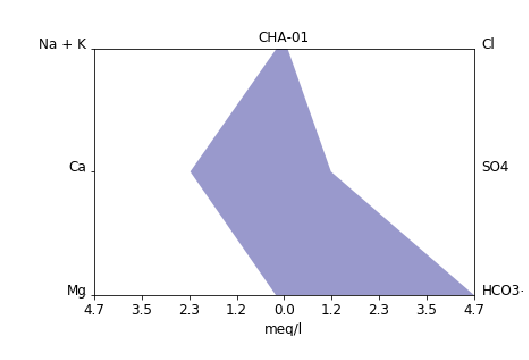

In [21]:
import matplotlib.pyplot as plt
stiffObject = plt.imread('../Png/Stiff-CHA-01.png')
fig, ax = plt.subplots(figsize=(10,6))
ax.axis('off')
ax.imshow(stiffObject)
plt.show()

### Generation of spatial file and style file
The observation points with their coordinates are exported in one file and the Stiff diagrams are linked on a style file.

In [5]:
#observation point spatial file
datosQuimicaGeo = datosQuimica.loc[:,'Este':'Norte']
datosQuimicaGeo.to_csv('../Txt/datosQuimicaGeo.csv')

In [6]:
#path to the Svg folder
imagePath = os.path.join(os.path.dirname(os.getcwd()),'Svg')
imagePath = imagePath.replace('\\','/')
imagePath

'C:/Users/GIDAWK1/Documents/GeoreferencedStiffDiagramwithPythonandQGIS/Svg'

In [7]:
#style file generation
archivoestilos = open('../Txt/estilosQuimicaGeo.sld','w')
archivoestilos.write(encabezado)

for index, row in datosQuimica.iterrows():
    item = re.sub('%%path%%',imagePath,item)
    estiloitem = re.sub('%%index%%',index,item)
    archivoestilos.write(estiloitem)
archivoestilos.write(final)

archivoestilos.close()